# Meta SSM for AR model

In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.kalman_filter import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Kalman filter model definition
time_step = 1           # Refer to 'Summary of imported time series data' for the reference time step
components = ['trend', 'ar']
hyperparameters = {'trend': {'process_error_var': 0.0},
                   'ar': {'phi': 0.91225, 'process_error_var': 0.05**2},
                   'observation': {'error': 1e-6}}
stationary_ar_var = hyperparameters['ar']['process_error_var'] / (1 - hyperparameters['ar']['phi']**2)

x_init = {'mu': np.array([0.,0, 0]), \
          'var': np.diag([0.00531, 1e-8, 6.36E-05])}

num_steps = 10000
anm_timestep = int(2/3 * num_steps)
anm_LT = 5e-2*hyperparameters['ar']['process_error_var']

In [3]:
ts_generator = generate_one_synthetic_time_series(components = components,\
                                time_step = time_step, \
                                hyperparameters = hyperparameters,\
                                num_steps = num_steps, \
                                time_step_interval = 1,\
                                x_init = x_init,\
                                insert_anomaly = True,\
                                anomaly_timesteps = [anm_timestep],\
                                anomaly_LT = [anm_LT],\
                                )
ts = ts_generator.time_series

true_AR = ts['y'] - anm_LT * (np.array(ts['timesteps']) - anm_timestep) * (np.array(ts['timesteps']) > anm_timestep)

In [4]:
# # Plot the generated time series
# plt.plot(ts['timesteps'], ts['y'])
# plt.show()

In [47]:
components = ['trend']
hyperparameters = {'trend': {'process_error_var': 1e-12 * stationary_ar_var},
                   'observation': {'error': stationary_ar_var}}

x_init = {'mu': np.array([0., 0]), \
          'var': np.diag([1e-8, 1e-10])}

kalman_runner = KalmanFilter(components = components,\
                                hyperparameters = hyperparameters,\
                                time_step=1)


x = x_init
mu_LL = []
var_LL = []
mu_LT = []
var_LT = []
for i in range(0, num_steps):
    y_pred, x_pred, _ = kalman_runner.predict(x)
    x, _, _ = kalman_runner.update(ts['y'][i])
    mu_LL.append(x['mu'][0])
    var_LL.append(x['var'][0, 0])
    mu_LT.append(x_pred['mu'][1])
    var_LT.append(x_pred['var'][1, 1])

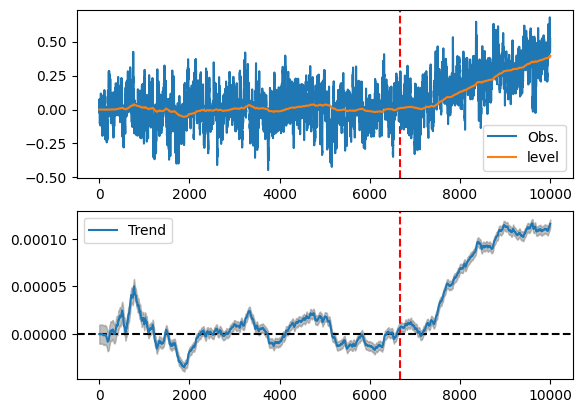

In [48]:
# Plot the results, time series and the Kalman filter estimates
# Two subfigure
fig, axs = plt.subplots(2)
axs[0].axvline(x=int(2/3 * num_steps), color='r', linestyle='--')
axs[0].plot(ts['timesteps'], ts['y'], label='Obs.')
axs[0].plot(ts['timesteps'], mu_LL, label='level')
axs[0].fill_between(ts['timesteps'], np.array(mu_LL) - np.array(var_LL)**0.5, np.array(mu_LL) + np.array(var_LL)**0.5, color = 'gray', alpha=0.5)
axs[0].legend()
# axs[0].set_ylim(-1, 5)

# horizontal line at y=0
axs[1].axvline(x=int(2/3 * num_steps), color='r', linestyle='--')
axs[1].axhline(y=0, color='k', linestyle='--')
axs[1].plot(ts['timesteps'], mu_LT, label='Trend')
axs[1].fill_between(ts['timesteps'], np.array(mu_LT) - np.array(var_LT)**0.5, np.array(mu_LT) + np.array(var_LT)**0.5, color = 'gray', alpha=0.5)
axs[1].legend()

plt.show()

In [49]:
components = ['autoregressive_acceleration', 'ar']
AA_ratio = 1e-18
hyperparameters = {'autoregressive_acceleration': {'process_error_var': 0, 'LA_process_error_var': 0.05**2 * AA_ratio, 'phi':0.999},
                   'ar': {'phi': 0.91225, 'process_error_var': 0.05**2},
                   'observation': {'error': stationary_ar_var}}

x_init = {'mu': np.array([0., 0., 0., 0.]), \
          'var': np.diag([1e-5, 1e-8, 0.05**2 * AA_ratio/(1-0.999**2), stationary_ar_var])}

kalman_runner = KalmanFilter(components = components,\
                                hyperparameters = hyperparameters,\
                                time_step=1)


x = x_init
mu_LL = []
var_LL = []
mu_LT = []
var_LT = []
mu_AA = []
var_AA = []
for i in range(0, num_steps):
    y_pred, x_pred, _ = kalman_runner.predict(x)
    x, _, _ = kalman_runner.update(ts['y'][i])
    mu_LL.append(x['mu'][0])
    var_LL.append(x['var'][0, 0])
    mu_LT.append(x_pred['mu'][1])
    var_LT.append(x_pred['var'][1, 1])
    mu_AA.append(x_pred['mu'][2])
    var_AA.append(x_pred['var'][2, 2])

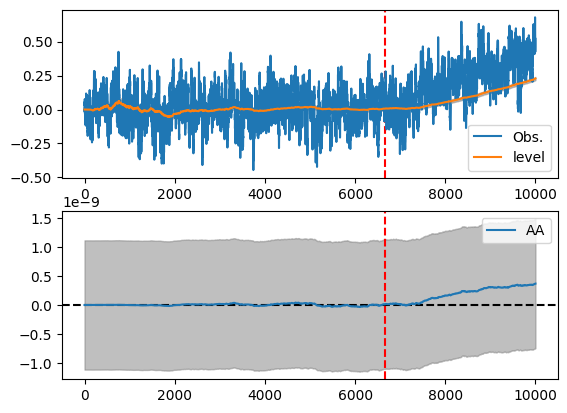

In [50]:
# Plot the results, time series and the Kalman filter estimates
# Two subfigure
fig, axs = plt.subplots(2)
axs[0].axvline(x=int(2/3 * num_steps), color='r', linestyle='--')
axs[0].plot(ts['timesteps'], ts['y'], label='Obs.')
axs[0].plot(ts['timesteps'], mu_LL, label='level')
axs[0].fill_between(ts['timesteps'], np.array(mu_LL) - np.array(var_LL)**0.5, np.array(mu_LL) + np.array(var_LL)**0.5, color = 'gray', alpha=0.5)
axs[0].legend()
# axs[0].set_ylim(-1, 5)

# horizontal line at y=0
axs[1].axvline(x=int(2/3 * num_steps), color='r', linestyle='--')
axs[1].axhline(y=0, color='k', linestyle='--')
axs[1].plot(ts['timesteps'], mu_AA, label='AA')
axs[1].fill_between(ts['timesteps'], np.array(mu_AA) - np.array(var_AA)**0.5, np.array(mu_AA) + np.array(var_AA)**0.5, color = 'gray', alpha=0.5)
axs[1].legend()

plt.show()